In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import pickle
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

### 载入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 载入数据集 (手势)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

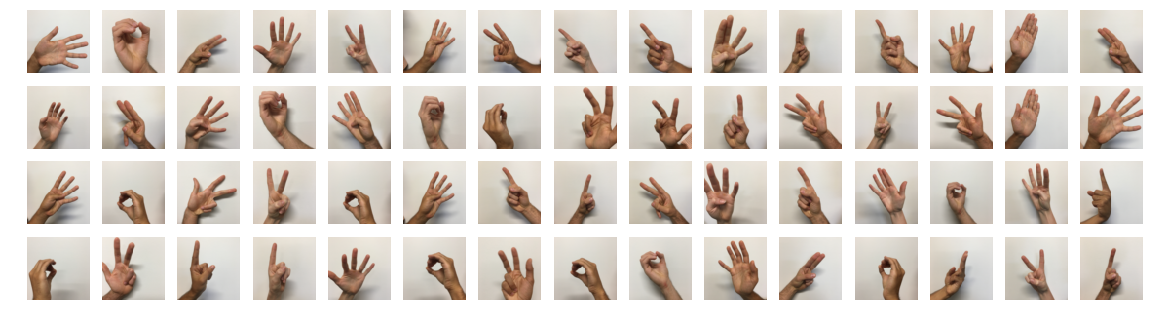

In [4]:
# 绘制训练样本图片集 前60张
X_orig = X_train_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

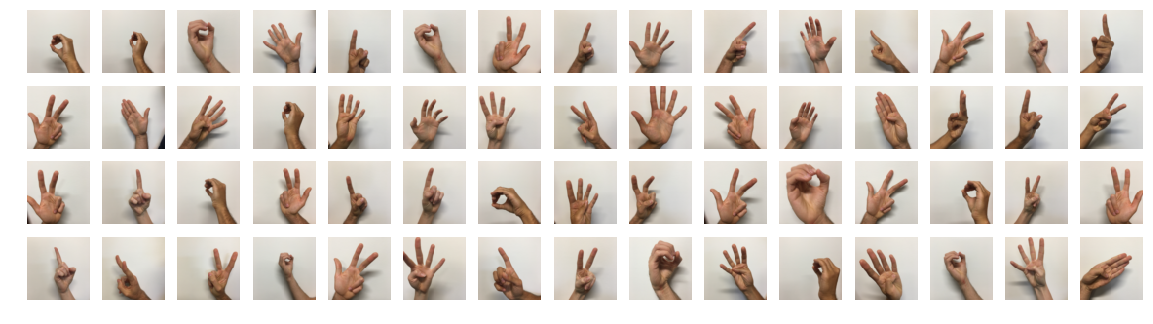

In [5]:
# 绘制测试样本图片集 前60张
X_orig = X_test_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

### 标准化输入

In [6]:
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 卷积神经网络
#### CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> SOFTMAX

In [7]:
# 将数据集随机打乱并分块
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0] # 样本数量
    mini_batches = []
    
    # Step 1: 打乱(X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: 分块(shuffled_X, shuffled_Y) 除尾部外
    num_complete_minibatches = math.floor(m / mini_batch_size) # 完整的mini batches数量
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # 处理尾部
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
# 显示所有测试集图片和预测结果
def print_all_test_images(p, y):
    num_images = len(X_test_orig)
    row = 15
    col = np.ceil(num_images / row)
    plt.rcParams['figure.figsize'] = (20, 25 * col / row)
    for i in range(num_images):
        plt.subplot(col, row, i + 1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.axis('off')
        if p[i] != y[i]:
            plt.title("%d (%d)" % (p[i], y[i]), color='red', fontweight='bold')

In [9]:
# 卷积神经网络模型
def cnn_model(X_train, Y_train, X_test, Y_test, parameters = None, learning_rate = 0.009, num_epochs = 100, 
              minibatch_size = 64, print_cost = True):
    # 重置tf变量，以重新运行模型
    ops.reset_default_graph()
    
    # 输入和输出的样本数量必须一致
    assert(X_train.shape[0] == Y_train.shape[0])
    
    # m 样本数量 
    # n_H0 * n_W0 * n_C0 样本图片像素大小和色彩通道数量
    m, n_H0, n_W0, n_C0 = X_train.shape
    
    # n_y 图片分类数量
    n_y = Y_train.shape[1]
    
    # 记录cost变化
    costs_train = []
    costs_test = []
    
    # 创建输入X和输出Y的Placeholders，设定正确的shape，第1维为样本数量，长度设为未知
    X = tf.placeholder(name='X', shape=(None, n_H0, n_W0, n_C0), dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=(None, n_y), dtype=tf.float32)
    
    # 参数初始化
    # W1 W2 为过滤器的参数
    if parameters is None:
        parameters = {}
        W1 = tf.get_variable(name='CONV1W', dtype=tf.float32, shape=(4, 4, 3, 8), initializer=tf.contrib.layers.xavier_initializer())
        W2 = tf.get_variable(name='CONV2W', dtype=tf.float32, shape=(2, 2, 8, 16), initializer=tf.contrib.layers.xavier_initializer())
    else:
        W1 = tf.get_variable(name='CONV1W', dtype=tf.float32, shape=(4, 4, 3, 8), initializer=tf.constant_initializer(parameters['CONV1W']))
        W2 = tf.get_variable(name='CONV2W', dtype=tf.float32, shape=(2, 2, 8, 16), initializer=tf.constant_initializer(parameters['CONV2W']))
    
    # 正向传播：建立正向传播路径图
    # CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=(1, 1, 1, 1), padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=(1, 8, 8, 1), strides=(1, 8, 8, 1), padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=(1, 1, 1, 1), padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=(1, 4, 4, 1), strides=(1, 4, 4, 1), padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. 
    if parameters is None:
        Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None, scope='fc1')
    else:
        Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None, 
                                               weights_initializer=tf.constant_initializer(parameters['FC1W']), 
                                               biases_initializer=tf.constant_initializer(parameters['FC1b']), 
                                               scope='fc1')
    
    # 损失函数: 将损失函数添加到路径图（包含softmax的交叉熵损失函数）
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Z3))
    
    # 反向传播: 使用Adam优化器最小化损失
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # 初始化全局变量
    init = tf.global_variables_initializer()
    
    # 开始session，计算路径图
    with tf.Session() as sess:
        # 初始化session
        sess.run(init)
        
        # 梯度下降法循环迭代进行训练
        for epoch in range(num_epochs):
            # 切割训练集并随机打乱，生成minibatches
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                # 选择一组minibatch
                minibatch_X, minibatch_Y = minibatch
                # 运行梯度下降
                sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
            
            # 打印当前epoch的cost
            if print_cost and epoch % 10 == 0:
                epoch_cost_train = sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost_test = sess.run(cost, feed_dict={X: X_test, Y: Y_test})
                costs_train.append(epoch_cost_train)
                costs_test.append(epoch_cost_test)
                if epoch % 20 == 0:
                    print ("Cost after epoch %i: %f(train) %f(test)" % (epoch, epoch_cost_train, epoch_cost_test))
                    
        # 绘制cost曲线 蓝色 - 训练集 红色 - 测试集
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(np.squeeze(costs_train), color='blue')
        plt.plot(np.squeeze(costs_test), color='red')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # 统计正确的预测
        correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
        
        # 计算训练集和测试集的准确率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        # 显示所有测试集图片和预测结果
        print_all_test_images(tf.argmax(Z3, 1).eval({X: X_test, Y: Y_test}), 
                              tf.argmax(Y, 1).eval({X: X_test, Y: Y_test}))
        
        # 记录参数 CONV1W CONV2W FC1W FC1b
        if parameters is None:
            parameters = {}
        
        parameters['CONV1W'] = W1
        parameters['CONV2W'] = W2
        
        all_vars= tf.global_variables()
        def get_var(name):
            for i in range(len(all_vars)):
                if all_vars[i].name.startswith(name):
                    return all_vars[i]
            return None
        
        fc1_weights = get_var('fc1/weights')
        fc1_bias = get_var('fc1/bias')
        
        parameters['FC1W'] = fc1_weights
        parameters['FC1b'] = fc1_bias
        
        parameters = sess.run(parameters)
        
        return parameters

### 训练模型

In [10]:
# 从文件中读取上次训练完毕的模型
parameters = None

try:
    fr = open('signs_cnn_parameters','rb')
    parameters = pickle.load(fr)
    fr.close()
except IOError:
    print("File is not accessible.")

Cost after epoch 0: 0.001363(train) 1.867715(test)
Cost after epoch 20: 0.001536(train) 1.893266(test)
Cost after epoch 40: 0.000979(train) 1.891883(test)
Cost after epoch 60: 0.000966(train) 1.944538(test)
Cost after epoch 80: 0.001247(train) 1.974883(test)


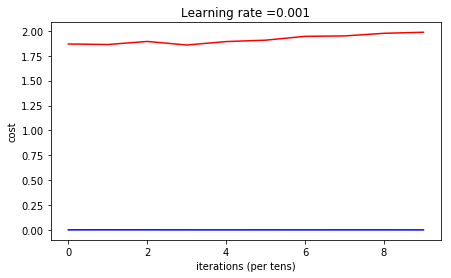

Train Accuracy: 1.0
Test Accuracy: 0.8333333


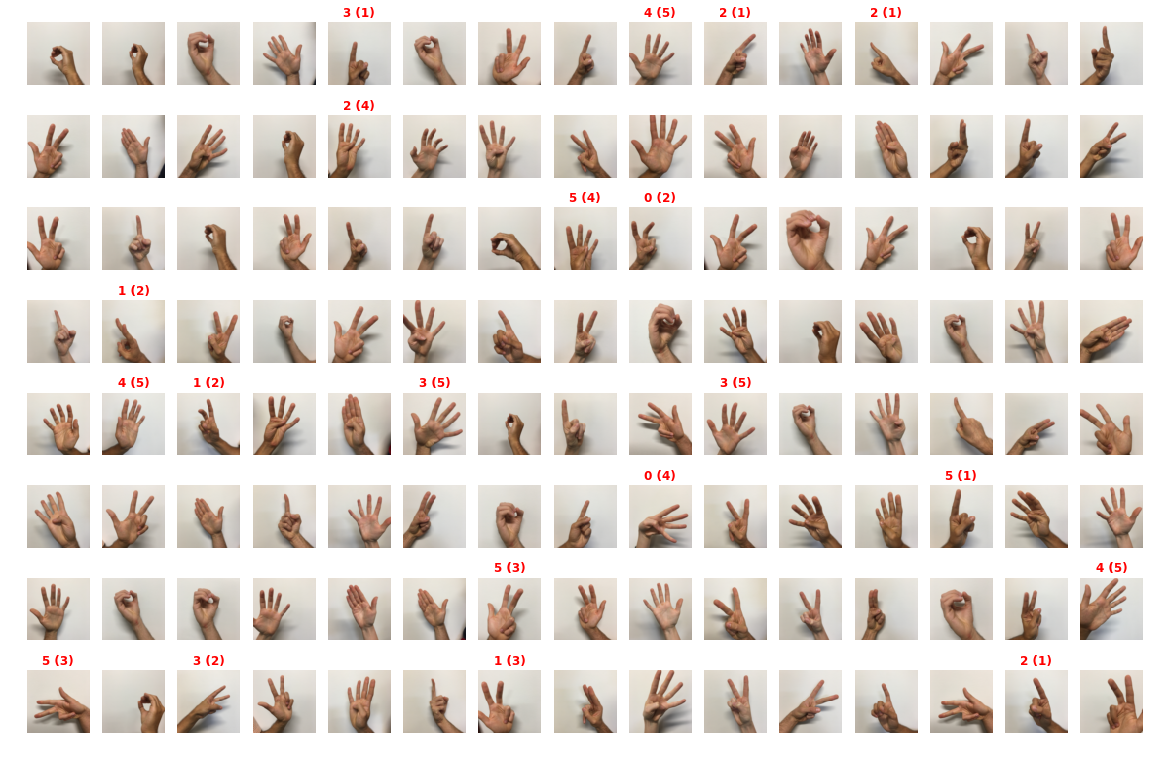

In [11]:
# 训练模型
parameters = cnn_model(X_train, Y_train, X_test, Y_test, parameters=parameters, learning_rate = 0.001, num_epochs=100)

In [12]:
# 将此次训练完毕的模型存入文件
try:
    fw = open('signs_cnn_parameters','wb')
    pickle.dump(parameters, fw)
    fw.close()
except IOError:
    print("File is not accessible.")

In [13]:
# 查看tf计算路径图中所有可训练的变量
tf.trainable_variables()

[<tf.Variable 'CONV1W:0' shape=(4, 4, 3, 8) dtype=float32_ref>,
 <tf.Variable 'CONV2W:0' shape=(2, 2, 8, 16) dtype=float32_ref>,
 <tf.Variable 'fc1/weights:0' shape=(64, 6) dtype=float32_ref>,
 <tf.Variable 'fc1/biases:0' shape=(6,) dtype=float32_ref>]

### 可视化

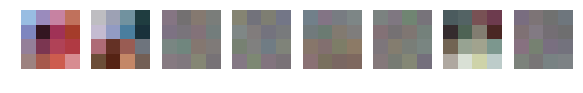

In [14]:
# 可视化卷积层1的8个4*4*3的过滤器
for i in range(8):
    plt.subplot(1, 16, i + 1)
    img = 1 / (1 + np.exp(-parameters['CONV1W'][:,:,:,i]))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

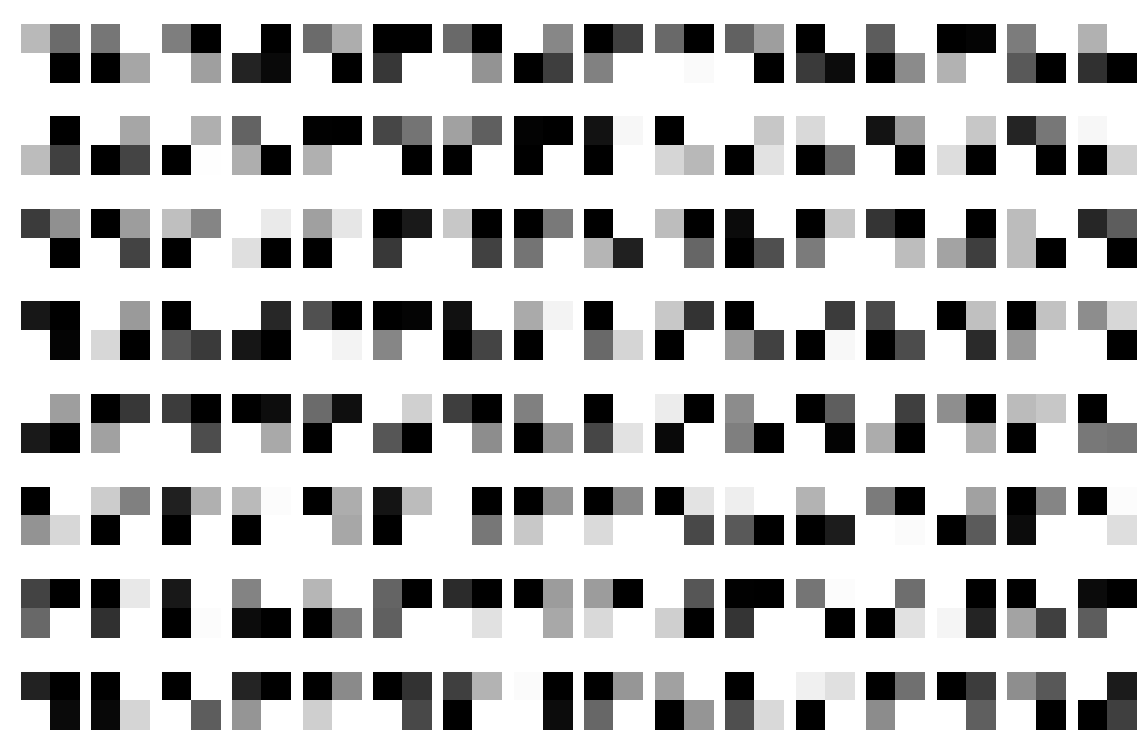

In [15]:
# 可视化卷积层2的16个2*2*8的过滤器
fig = plt.figure()
for i in range(16):
    for j in range(8):
        ax = fig.add_subplot(8, 16, j * 16 + i + 1)
        ax.matshow(1 / (1 + np.exp(-parameters['CONV2W'][:, :, j, i])), cmap=plt.get_cmap('gray'), interpolation='nearest')
        ax.axis('off')
plt.show()

In [16]:
# 可视化卷积神经网络模型
def visualize_cnn(X_train, parameters, sample_index):
    # 重置tf变量，以重新运行模型
    ops.reset_default_graph()

    # m 样本数量 
    # n_H0 * n_W0 * n_C0 样本图片像素大小和色彩通道数量
    m, n_H0, n_W0, n_C0 = X_train.shape

    # 创建输入X的Placeholders，设定正确的shape，第1维为样本数量，长度设为未知
    X = tf.placeholder(name='X', shape=(None, n_H0, n_W0, n_C0), dtype=tf.float32)

    # 参数初始化
    # W1 W2 为过滤器的参数
    W1 = tf.get_variable(name='CONV1W', dtype=tf.float32, shape=(4, 4, 3, 8), initializer=tf.constant_initializer(parameters['CONV1W']))
    W2 = tf.get_variable(name='CONV2W', dtype=tf.float32, shape=(2, 2, 8, 16), initializer=tf.constant_initializer(parameters['CONV2W']))

    # 正向传播：建立正向传播路径图
    # CONV2D -> RELU -> MAXPOOL
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=(1, 1, 1, 1), padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=(1, 8, 8, 1), strides=(1, 8, 8, 1), padding='SAME')
    
    # 初始化全局变量
    init = tf.global_variables_initializer()

    # 开始session
    with tf.Session() as sess:
        # 初始化session
        sess.run(init)
        
        Z1_mat = sess.run(Z1,feed_dict={X: X_train})
        A1_mat = sess.run(A1,feed_dict={X: X_train})
        P1_mat = sess.run(P1,feed_dict={X: X_train})

        fig = plt.figure(figsize=(24, 10))
        
        # 绘制样本原图
        ax0 = fig.add_subplot(4, 8, 1)
        ax0.imshow(X_train[sample_index], interpolation='nearest')
        ax0.axis('off')
        
        for i in range(8):
            # 绘制卷积层Z1 经过卷积
            ax1 = fig.add_subplot(4, 8, i + 9)
            ax1.matshow(1 / (1 + np.exp(-Z1_mat[sample_index, :, :, i])), cmap=plt.get_cmap('gray'), interpolation='nearest')
            ax1.axis('off')

            # 绘制卷积层A1 经过ReLU激活函数
            ax2 = fig.add_subplot(4, 8, i + 17)
            ax2.matshow(1 / (1 + np.exp(-A1_mat[sample_index, :, :, i])), cmap=plt.get_cmap('gray'), interpolation='nearest')
            ax2.axis('off')

            # 绘制卷积层P1 经过池化
            ax3 = fig.add_subplot(4, 8, i + 25)
            ax3.matshow(1 / (1 + np.exp(-P1_mat[sample_index, :, :, i])), cmap=plt.get_cmap('gray'), interpolation='nearest')
            ax3.axis('off')

        plt.show()

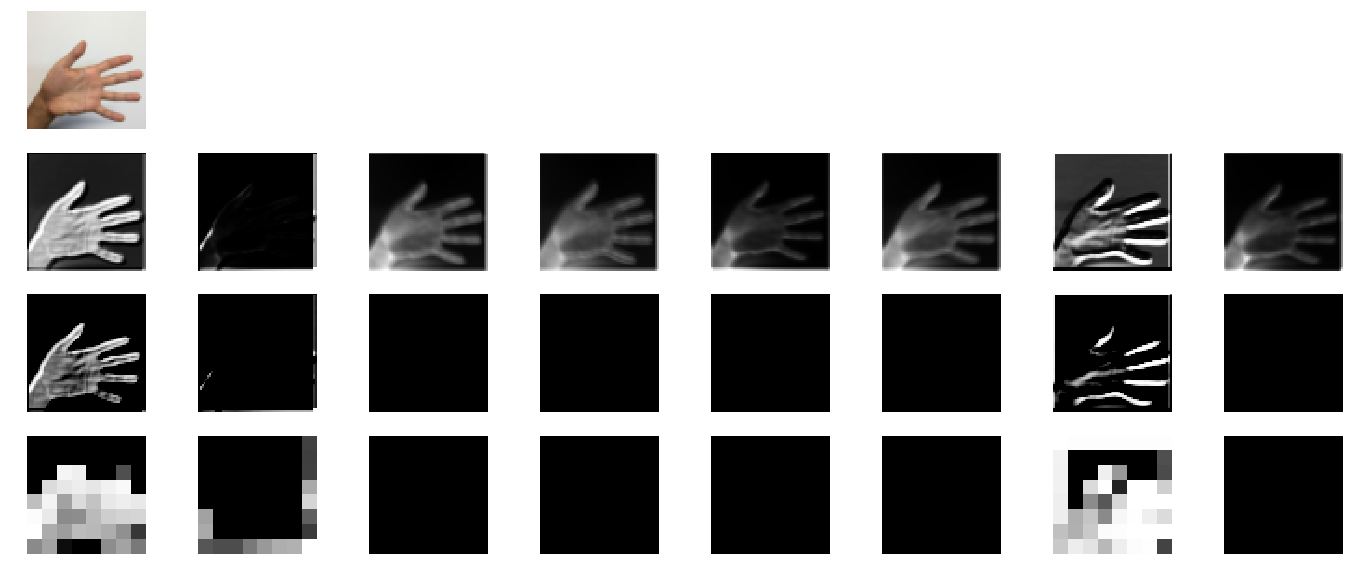

In [17]:
# 绘制样本0的卷积层1可视化图形
visualize_cnn(X_train, parameters, 0)

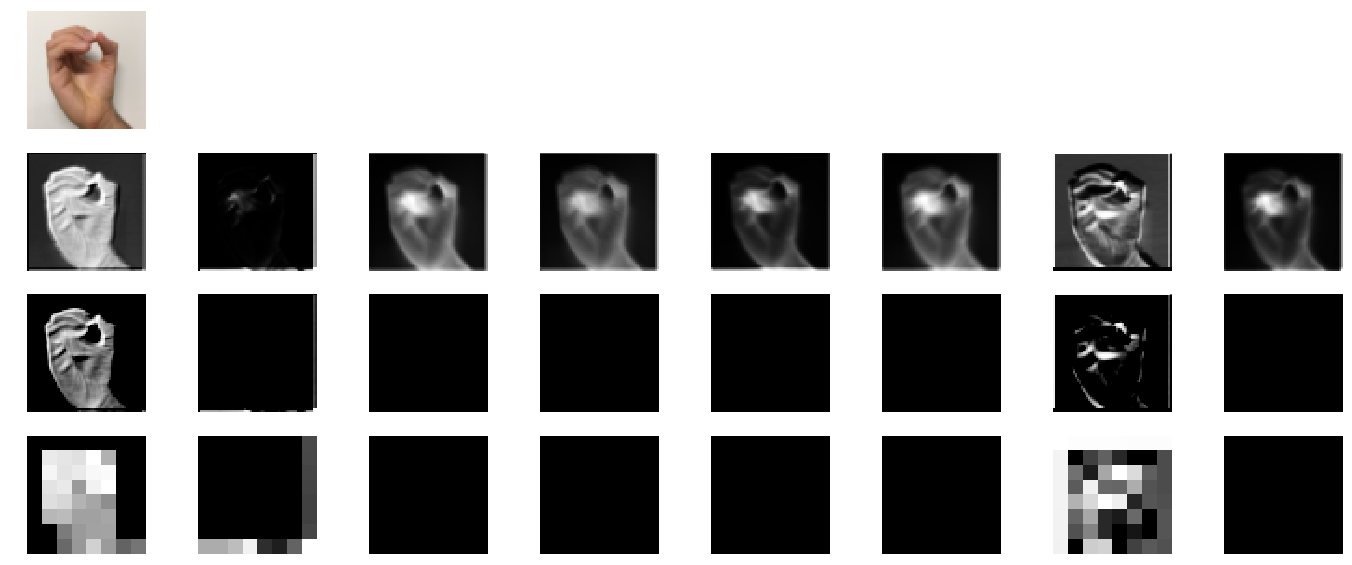

In [18]:
# 绘制样本1的卷积层1可视化图形
visualize_cnn(X_train, parameters, 1)

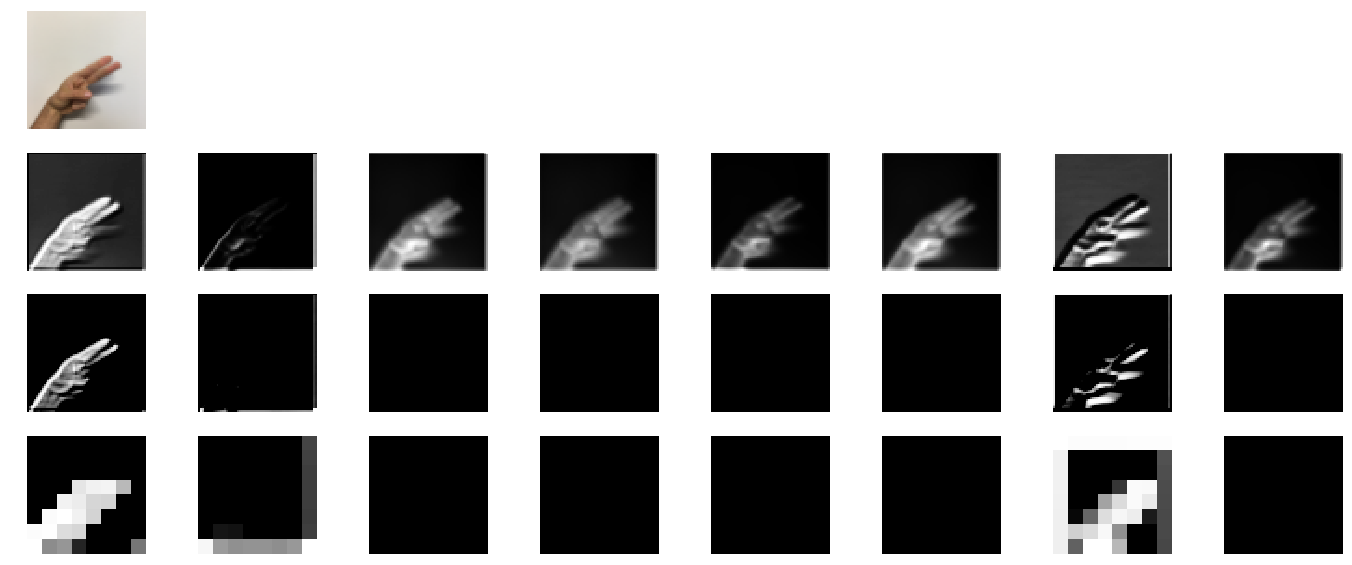

In [19]:
# 绘制样本2的卷积层1可视化图形
visualize_cnn(X_train, parameters, 2)